# Scaling from mendes santos paper
1. **import data** 
1. **define scaling functions**
1. **make parameter mesh**
1. **plot 3d scatter**

In [379]:
import numpy as np
import matplotlib.pyplot as plt
from fssa import quality
from tqdm import tqdm
import plotly.graph_objects as go
import numpy as np
import seaborn as sns
from scipy.optimize import minimize

## Import data

In [397]:
rho = np.linspace(0.1,6.1,31)
Ls= np.arange(8,16,2).astype(float)

Y = np.zeros((len(Ls),len(rho)))
dY = np.zeros((len(Ls),len(rho)))
for index, L in enumerate(Ls):
    data = np.load('data/cluster/'+'2nn-{}-combined.npy'.format(int(L)))
    Y[index] = np.mean(data,axis=0)
    dY[index] = np.std(data,axis=0)
    

rho = rho[5:]
Y = Y[:,5:]
dY = dY[:,5:]

## scale data func.

In [398]:
def x_dat_2_new(rho, rho_c, l, nu):
    return np.power(l, 1./nu) * (rho-rho_c)

def x_BKT(rho, rho_c, l, nu):
    return np.power(l* np.exp(abs((rho-rho_c))), 1./nu)

def x_BKT(rho, rho_c, l, nu):
    return np.power(l* np.exp(np.sqrt(abs(rho-rho_c))), 1./nu)

def x_BKT(rho, rho_c, l, nu):
    return l*np.exp(-1.4/np.sqrt(abs(rho-rho_c)))


def y_dat_new(y, l, zeta,nu):
    return np.power(l, -zeta/nu) * y


l_mesh_local, rho_mesh_local = np.meshgrid(Ls, rho, indexing='ij')

def goal_function(rho_c = 3., nu=2.2, zeta=1.2):

    #XX = x_dat_2_new(rho=rho_mesh_local, rho_c=rho_c, l=l_mesh_local ,nu=nu) 
    XX = x_BKT(rho=rho_mesh_local, rho_c=rho_c, l=l_mesh_local ,nu=nu) 
    
    
    YY = y_dat_new(y=Y, l=l_mesh_local, zeta=zeta, nu=nu)
    #print('y',YY)
    dYY = y_dat_new(y=dY, l=l_mesh_local, zeta=zeta, nu=nu)
    #print('dy',dYY)
    
    # sorting for BKT
    sorting_index = np.argsort(XX)[0]
    #print(sorting_index)
    
    XX = XX[:,sorting_index]
    YY = YY[:,sorting_index]
    dYY = dYY[:, sorting_index]
    
    
    return quality(XX,YY,dYY)
    

In [399]:
goal_function()

1.2955174955843305

1
1.5
2
nu = [1, 1.5, 2] (vertical)
zeta = [1.5, 2, 2.5] (horizontal)


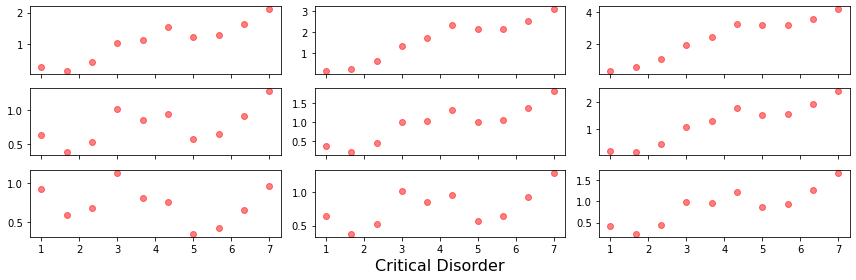

In [400]:
fig, ax = plt.subplots(3,3, figsize=(12,4), sharex=True)

for index0, nu in enumerate([1,1.5,2]):
    print(nu)
    for index1, zeta in enumerate([1.5,2,2.5]):
        for r in np.linspace(1,7,10):
            ax[index0,index1].scatter(r,goal_function(r,nu,zeta), c='r', alpha=.5)
            
print('nu = [1, 1.5, 2] (vertical)')
print('zeta = [1.5, 2, 2.5] (horizontal)')

ax[2,1].set_xlabel('Critical Disorder', fontsize=16)




            
plt.tight_layout()

## Free param mesh

In [465]:
rho_c_for_mesh = np.linspace(3.2,4.0,30)
nu_for_mesh = np.linspace(1.95,2.05,3)
zeta_for_mesh = np.linspace(1.95,2.05,3)

rho_c_mesh, nu_mesh, zeta_mesh = np.meshgrid(rho_c_for_mesh,nu_for_mesh,zeta_for_mesh,indexing='ij')
quality_mesh = np.zeros(np.shape(rho_c_mesh))

## calculate quality for each mesh point

In [466]:
real_data = []

for index3, rho_3, nu_3, z_3 in tqdm(zip(range(len(rho_c_mesh)),rho_c_mesh , nu_mesh, zeta_mesh)):
    for index2, rho_2, nu_2, z_2 in zip(range(len(rho_3)),rho_3, nu_3, z_3):
        for index1, rho_1, nu_1, z_1 in zip(range(len(rho_2)),rho_2, nu_2, z_2):
            q = goal_function(rho_1, nu_1, z_1)
            quality_mesh[index3,index2,index1] = q
            real_data.append([rho_1, nu_1, z_1, q])
            #print(quality_mesh)
            
real_data = np.array(real_data)

30it [00:02, 12.11it/s]


In [467]:
sum(real_data[:,3] != quality_mesh.flatten())

0

## Plot

In [468]:
### import plotly.graph_objects as go
import numpy as np

#size = 1/((quality_mesh.flatten()/np.max(quality_mesh.flatten()))**1)
size = 1/quality_mesh.flatten()**5*5

fig = go.Figure(data=[go.Scatter3d(x=rho_c_mesh.flatten(), 
                                   y=nu_mesh.flatten(), 
                                   z=zeta_mesh.flatten(),
                                   mode='markers',
                                  marker=dict(
                                            size=size,
                                            color=size,          # set color to an array/list of desired values
                                    colorscale='inferno',   # choose a colorscale
                                    opacity=0.8,
                                      
                                ))])
fig.show()

i had used the scaling func from Mendez-santos: where $x = np.power(l, -a) * y$ and $y = np.power(l, 1./nu) * (rho-rho_c)$. Now having changed to $x = np.power(l, -zeta/nu) * y$

In [405]:
def goal_function_min(x):
    rho_c = x[0] 
    nu = x[1]
    zeta=x[2]

    #XX = x_dat_2_new(rho=rho_mesh_local, rho_c=rho_c, l=l_mesh_local ,nu=nu) 
    XX = x_BKT(rho=rho_mesh_local, rho_c=rho_c, l=l_mesh_local ,nu=nu) 
    
    
    YY = y_dat_new(y=Y, l=l_mesh_local, zeta=zeta, nu=nu)
    #print('y',YY)
    dYY = y_dat_new(y=dY, l=l_mesh_local, zeta=zeta, nu=nu)
    #print('dy',dYY)
    
    # sorting for BKT
    sorting_index = np.argsort(XX)[0]
    #print(sorting_index)
    
    XX = XX[:,sorting_index]
    YY = YY[:,sorting_index]
    dYY = dYY[:, sorting_index]
    
    
    return quality(XX,YY,dYY)

In [469]:
minimize(goal_function_min,x0=[3.,1.,2.], bounds=((2,4),(1.,2.5),(1,2.5)))

      fun: 0.7689834212100658
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00329848,  0.000101  , -0.00040911])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 200
      nit: 12
     njev: 50
   status: 0
  success: True
        x: array([3.7895557 , 2.09261357, 1.38245338])

In [470]:
import fssa

In [471]:
def scaledata(l, rho, a, da, rho_c, nu, zeta):
    r'''
    Scale experimental data according to critical exponents

    Parameters
    ----------
    l, rho : 1-D array_like
       finite system sizes `l` and parameter values `rho`

    a, da : 2-D array_like of shape (`l`.size, `rho`.size)
       experimental data `a` with standard errors `da` obtained at finite
       system sizes `l` and parameter values `rho`, with
       ``a.shape == da.shape == (l.size, rho.size)``

    rho_c : float in range [rho.min(), rho.max()]
       (assumed) critical parameter value with ``rho_c >= rho.min() and rho_c
       <= rho.max()``

    nu, zeta : float
       (assumed) critical exponents

    Returns
    -------
    :py:class:`ScaledData`
       scaled data `x`, `y` with standard errors `dy`

    x, y, dy : ndarray
       two-dimensional arrays of shape ``(l.size, rho.size)``

    Notes
    -----
    Scale data points :math:`(\varrho_j, a_{ij}, da_{ij})` observed at finite
    system sizes :math:`L_i` and parameter values :math:`\varrho_i` according
    to the finite-size scaling ansatz

    .. math::

       L^{-\zeta/\nu} a_{ij} = \tilde{f}\left( L^{1/\nu} (\varrho_j -
       \varrho_c) \right).

    The output is the scaled data points :math:`(x_{ij}, y_{ij}, dy_{ij})` with

    .. math::

       x_{ij} & = L_i^{1/\nu} (\varrho_j - \varrho_c) \\
       y_{ij} & = L_i^{-\zeta/\nu} a_{ij} \\
       dy_{ij} & = L_i^{-\zeta/\nu} da_{ij}

    such that all data points :ref:`collapse <data-collapse-method>` onto the
    single curve :math:`\tilde{f}(x)` with the right choice of
    :math:`\varrho_c, \nu, \zeta` [4]_ [5]_.

    Raises
    ------
    ValueError
       If `l` or `rho` is not 1-D array_like, if `a` or `da` is not 2-D
       array_like, if the shape of `a` or `da` differs from ``(l.size,
       rho.size)``

    References
    ----------

    .. [4] M. E. J. Newman and G. T. Barkema, Monte Carlo Methods in
       Statistical Physics (Oxford University Press, 1999)

    .. [5] K. Binder and D. W. Heermann, `Monte Carlo Simulation in Statistical
       Physics <http://dx.doi.org/10.1007/978-3-642-03163-2>`_ (Springer,
       Berlin, Heidelberg, 2010)
    '''

    # l should be 1-D array_like
    l = np.asanyarray(l)
    if l.ndim != 1:
        raise ValueError("l should be 1-D array_like")

    # rho should be 1-D array_like
    rho = np.asanyarray(rho)
    if rho.ndim != 1:
        raise ValueError("rho should be 1-D array_like")

    # a should be 2-D array_like
    a = np.asanyarray(a)
    if a.ndim != 2:
        raise ValueError("a should be 2-D array_like")

    # a should have shape (l.size, rho.size)
    if a.shape != (l.size, rho.size):
        raise ValueError("a should have shape (l.size, rho.size)")

    # da should be 2-D array_like
    da = np.asanyarray(da)
    if da.ndim != 2:
        raise ValueError("da should be 2-D array_like")

    # da should have shape (l.size, rho.size)
    if da.shape != (l.size, rho.size):
        raise ValueError("da should have shape (l.size, rho.size)")

    # rho_c should be float
    rho_c = float(rho_c)

    # rho_c should be in range
    if rho_c > rho.max() or rho_c < rho.min():
        warnings.warn("rho_c is out of range", RuntimeWarning)

    # nu should be float
    nu = float(nu)

    # zeta should be float
    zeta = float(zeta)

    l_mesh, rho_mesh = np.meshgrid(l, rho, indexing='ij')

    x = np.power(l_mesh, 1. / nu) * (rho_mesh - rho_c)
    x = l_mesh*np.exp(-1.4/np.sqrt(abs(rho_mesh-rho_c)))
    y = np.power(l_mesh, - zeta / nu) * a
    dy = np.power(l_mesh, - zeta / nu) * da

    sorting_index = np.argsort(x)[0]
    
    x = x[:,sorting_index]
    y = y[:,sorting_index]
    dy = dy[:, sorting_index]

    return ScaledData(x, y, dy)

KeyboardInterrupt: 

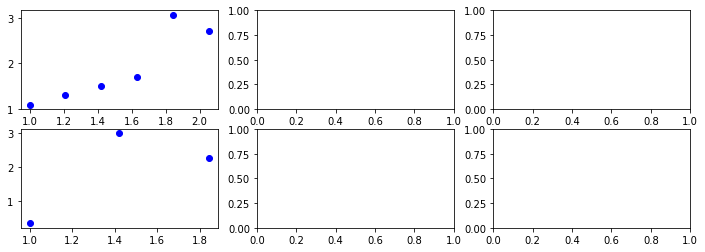

In [472]:

fig, ax = plt.subplots(2,3, figsize=(12,4))


for rho0 in np.linspace(1,5,20):
    res = fssa.autoscale(Ls, rho, Y, dY,rho0,2,2)
    ax[0,0].scatter(rho0, res['rho'], c='b',)
    ax[1,0].scatter(rho0, res['drho'], c='b')
    
print('rho done')
for nu0 in np.linspace(1,5,20):
    res = fssa.autoscale(Ls, rho, Y, dY,3.6,nu0,2)
    ax[0,1].scatter(nu0, res['nu'],c='r')
    ax[1,1].scatter(nu0, res['dnu'],c='r')

print('nu done')
for zeta0 in np.linspace(1,5,20):
    res = fssa.autoscale(Ls, rho, Y, dY,3.6,2,zeta0)
    ax[0,2].scatter(zeta0, res['zeta'],c='g')
    ax[1,2].scatter(zeta0, res['dzeta'],c='g')

plt.tight_layout()

In [478]:
fssa.autoscale(Ls, rho, Y, dY,2,2,2)

           dnu: 0.5538610487963777
          drho: nan
         dzeta: nan
        errors: array([       nan, 0.55386105,        nan])
 final_simplex: (array([[3.83374774, 0.86503919, 0.76805308],
       [3.8280435 , 0.86519184, 0.76486041],
       [3.83151126, 0.86563381, 0.76354296],
       [3.82552267, 0.87007601, 0.77411832]]), array([0.06367994, 0.06369196, 0.06373293, 0.06401667]))
           fun: 0.06367993622763195
       message: 'Optimization terminated successfully.'
          nfev: 77
           nit: 43
            nu: 0.865039193930702
           rho: 3.8337477396554354
        status: 0
       success: True
         varco: array([[-2.22307289,  0.52536913,  1.2870811 ],
       [ 0.52536913,  0.30676206,  0.20848331],
       [ 1.2870811 ,  0.20848331, -0.06745604]])
             x: array([3.83374774, 0.86503919, 0.76805308])
          zeta: 0.7680530834830863